### Testing PAR-2 alleles with a combination of point mutations in the RING domain

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
sys.path.append('../../..')
from src import bounded_mean_1d, dataplot, bootstrap_effect_size_pd
import matplotlib.transforms as transforms
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

if not os.path.exists('Figs'):
    os.mkdir('Figs')

### Quantification

In [2]:
df = pd.read_csv("../../../data/par2_nebd_embryos.csv")
df_quantification = pd.read_csv("../../../data/par2_nebd_quantification.csv")
df_quantification_grouped = df_quantification.groupby("EmbryoID")

df_summary = pd.DataFrame()
for i, r in df_quantification_grouped:
    cyt = np.mean(r["Cytoplasmic signal"])
    mem_tot = np.mean(r["Membrane signal"])
    mem_ant = bounded_mean_1d(r["Membrane signal"], [0.4, 0.6])
    mem_post = bounded_mean_1d(r["Membrane signal"], [0.9, 0.1])
    ratio_post = mem_post / cyt
    p = {
        "EmbryoID": i,
        "Cyt": cyt,
        "Mem_tot": mem_tot,
        "Mem_ant": mem_ant,
        "Mem_post": mem_post,
        "Ratio post": ratio_post,
    }
    df_summary = df_summary.append(pd.DataFrame(p, index=[i]))
df = pd.merge(df, df_summary, on="EmbryoID")

# Filter
df = df[df.Line.isin(["lp637", "nwg240", "nwg338", "nwg400", "nwg407", "nwg351"])]

# Add genotype column
genotype_dict = {
    "lp637": "WT",
    "nwg240": "C56S",
    "nwg338": "L109R",
    "nwg400": "L50R",
    "nwg407": "C56S+L109R",
    "nwg351": "L50R+L109R",
}
df["Genotype"] = [genotype_dict[a] for a in df["Line"]]

### Figure

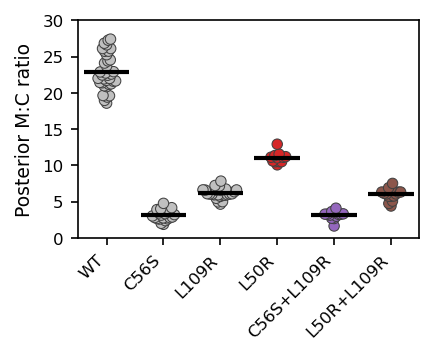

In [4]:
_df = df[df.RNAi == "wt"]

# Set up figure
fig, ax = plt.subplots()
fig.set_size_inches(15, 2.5)
offset = lambda p: transforms.ScaledTranslation(p / 72.0, 0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

# Color pallete
order = ["WT", "C56S", "L109R", "L50R", "C56S+L109R", "L50R+L109R"]
colors = ["silver", "silver", "silver", "tab:red", "tab:purple", "tab:brown"]

# Plot data
dataplot(
    data=_df,
    x="Genotype",
    y="Ratio post",
    ax=ax,
    order=order,
    linewidth=0.5,
    palette=colors,
    width=0.8,
    linewidth_mean=2,
    transform=trans + offset(0),
)

# Finalise figure
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment("right")

ax.tick_params(axis="both", labelsize=8)
ax.set_xlabel("")
ax.set_ylim(0, 30)
ax.set_ylabel("Posterior M:C ratio", fontsize=9)
fig.set_size_inches(3.5, 2.5)
fig.subplots_adjust(left=0.25, bottom=0.3)
fig.savefig("Figs/mcr.png", dpi=600, transparent=True)

In [5]:
# Effect size L50R vs WT
es1 = bootstrap_effect_size_pd(data=_df, x="Genotype", y="Ratio post", a="WT", b="L50R")
print(np.mean(es1), np.percentile(es1, [2.5, 97.5]))

# Effect size C56S+L109R vs C56S
es2 = bootstrap_effect_size_pd(
    data=_df, x="Genotype", y="Ratio post", a="C56S", b="C56S+L109R"
)
print(np.mean(es2), np.percentile(es2, [2.5, 97.5]))

# Effect size L50R+L109R vs L109R
es3 = bootstrap_effect_size_pd(
    data=_df, x="Genotype", y="Ratio post", a="L109R", b="L50R+L109R"
)
print(np.mean(es3), np.percentile(es3, [2.5, 97.5]))

-11.861834372035418 [-12.76958079 -10.97704933]
-0.026331810621100137 [-0.47693649  0.37443897]
-0.19569401657582514 [-0.71297164  0.28602058]
